## Import packages

In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import wandb

In [38]:
# Initialize Weights and Biases
run = wandb.init(project="Fire_SC", job_type = 'fit model with weekly mean data')

In [2]:
dfp1 = pd.read_csv(r'C:\Users\coach\myfiles\postdoc\Fire\data\v2_2019_08.csv', index_col = 0)
dfn1 = pd.read_csv(r'C:\Users\coach\myfiles\postdoc\Fire\data\v2_2019_08_neg.csv', index_col = 0)
df1 = pd.concat([dfp1, dfn1], axis = 0)

In [3]:
dfp2 = pd.read_csv(r'C:\Users\coach\myfiles\postdoc\Fire\data\v2_2020_08.csv', index_col = 0)
dfn2 = pd.read_csv(r'C:\Users\coach\myfiles\postdoc\Fire\data\v2_2020_08_neg.csv', index_col = 0)
df2 = pd.concat([dfp2, dfn2], axis = 0)
df = pd.concat([df1.reset_index(), df2.reset_index()], axis=0)

In [4]:
df['target'] = np.where(df['areakm2_BA'] > 0, 1, 0)

In [8]:
Xcols = df.filter(like='_p').columns.tolist()
ycols = 'target'

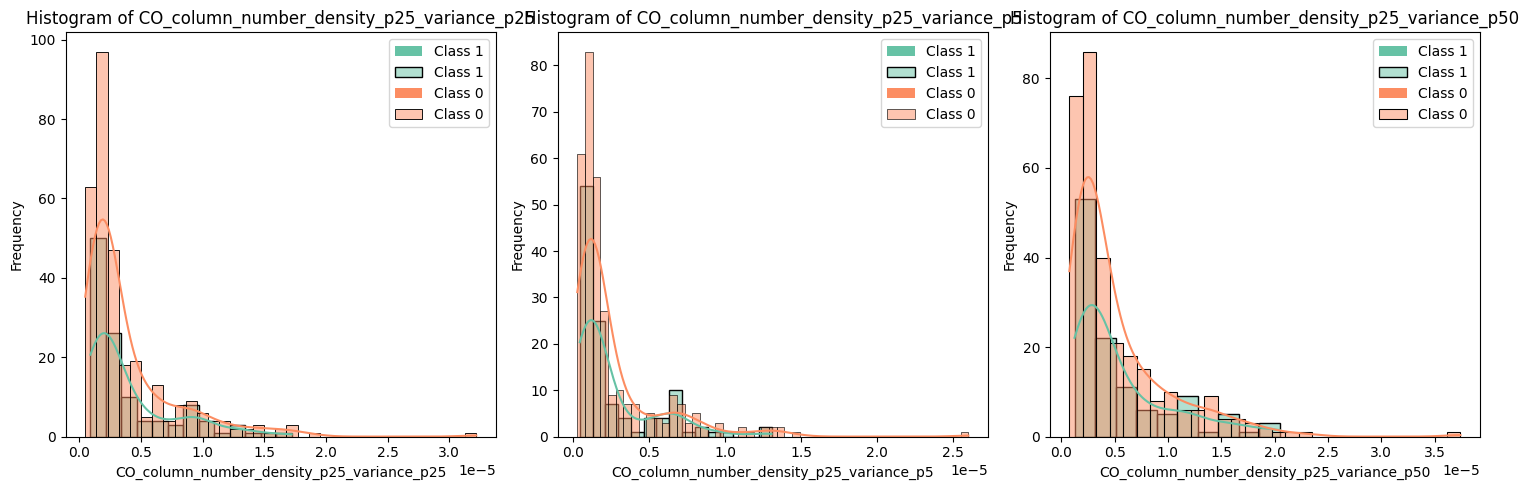

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns  # for color palette
import pandas as pd

# Assuming you have a DataFrame named df with columns column1, column2, column3, and target_class
# You can use sns to set a color palette for the target_class
sns.set_palette("Set2")

# Split the DataFrame by target class
classes = df['target'].unique()

# Create subplots for each column
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Get the first 5 predictors
predictors = df[Xcols].iloc[:, :3]

# Plot histograms for the first three columns, colored by target class
for i, col in enumerate(predictors.columns):
    ax = axes[i]
    for target in classes:
        sns.histplot(df[df['target'] == target][col], kde=True, label=f'Class {target}', ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [43]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(df[Xcols], df[ycols], test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(286, 36) (286,) (142, 36) (142,)


## Create a naive baseline ('predict' mode class)

In [44]:
from scipy.stats import mode
# Predict the mode class for all instances
mode_class = mode(y_train).mode[0]
baseline_predictions = [mode_class] * len(y_test)

# Calculate accuracy of the baseline
accuracy = accuracy_score(y_test, baseline_predictions)

print(f"Naive Baseline Accuracy: {accuracy:.2f}")

Naive Baseline Accuracy: 0.75


C:\Users\coach\AppData\Local\Temp\ipykernel_15576\3807130582.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_class = mode(y_train).mode[0]


## Try Tabular models- random forest

In [52]:
model = RandomForestClassifier(class_weight="balanced", random_state=42).fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       106
           1       0.29      0.19      0.23        36

    accuracy                           0.68       142
   macro avg       0.52      0.52      0.51       142
weighted avg       0.64      0.68      0.65       142

Confusion Matrix:


Accuracy,▁▁▁▁▁▁█
n_Negative Examples,▁▁▁▁▁▁▁
n_Positive Examples,▁▁▁▁▁▁▁
Accuracy,0.67606
Classification Report,precis...
n_Negative Examples,312
n_Positive Examples,116


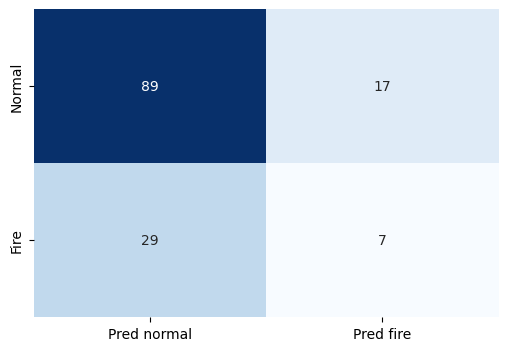

In [53]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Log evaluation metrics, model name, and counts to Weights and Biases
run.log({"Accuracy": accuracy, "n_Positive Examples": df[df.target==1].shape[0], "n_Negative Examples": df[df.target==0].shape[0]})
run.log({"Classification Report": classification_rep})
# wandb.log({"pr": wandb.plot.confusion_matrix(y_true = y_test, preds = y_pred)})

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion, index=['Normal', 'Fire'], columns=['Pred normal', 'Pred fire'])

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_rep)

print('Confusion Matrix:')
# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)

run.finish()